# Investigating College Sexual Assault Data 

This notebook explores college sexual assault data collected from 2005 - 2015. All data was downloaded from https://ope.ed.gov/campussafety/#/datafile/list

In addition, this notebook gathers Title IX investigation data from http://projects.chronicle.com/titleix/api/v1/docs/

This notebook essentially generates a Python Pandas DataFrame of information about colleges sexual violence instances in on-campus residence halls: how many sexual crimes were recorded in a given year, the male / female enrollment in a given year, and total number of Title IX investigations a college has endured. Note: the male / female enrollment data is included because it is easily accessible and interesting, however, I am not incinuiating that there is at all a correlation or causal effect between male / female enrollment data and sexual assault information (other than more people would imply more likely to have sexual assaults). The DataFrame I generate is eventually written to a CSV file and then used to generate a MongoDB database which serves as the back-end for a website. 

This data was collected and is presented in part for a final project for Ethical Reasoning 42: Sexual Ethics

## 1. Importing Necessary Dependencies and Data Aggregating

Warning: this part is very code heavy. Here we import the necessary dependencies, read in, and aggreagate all of the data. 

Some of the challenges with this were that the data was seperated and collected in three year intervals, such that data in the 2005-2007 spreadsheet could later be overwritten by data in the 2006-2008 spreadhseet. In addition, it was hard to come up with a good "programmatic" way to do merge all of the data: data was collected differently in different years. This code is still not really as nice as it could be (but is code ever as good as it could be?): it doesn't do any error handling, and even though it tries to extract out commonalities it has to be pretty specific to various spreadsheets because of differences in data collection. 

Prior to 2014, sexual assault crime was either considered "forcible" or "non-forcible." In 2014, this category was changed such that sexual crime was classified as "rape," "statutory rape," "incest," or "fondling." Here, I aggreagte all of the data from 2005 - 2015 on sexual crimes classified as forcible, non-forcible, rape, statutory rape, or fondling. For the purposes of this investigation, I do not consider incest to be sexual crime. Because data on male / female enrollment, college id, location, etc. is readily available, I also keep track of that. I do not consider crimes that aren't sexual in nature.

In [275]:
import pandas as pd 
import numpy as np
import requests
from functools import reduce
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [122]:
# classic capitalizing some years and not others
YEAR_DEPENDENT = ['FORCIB', 'NONFOR']
COL_NAMES = ['UNITID_P', 'INSTNM', 'City', 'State', 'men_total', 'women_total']
CSV_LIST = ['Residencehallcrime050607.xls', 
            'Residencehallcrime060708.xls', 
            'Residencehallcrime070809.xls', 
            'Residencehallcrime080910.xls', 
            'Residencehallcrime091011.xls', 
            'Residencehallcrime101112.xls', 
            'residencehallcrime111213.xls', 
            'residencehallcrime121314.xls', 
            'residencehallcrime131415.xls']

In [295]:
def generate_df(csv_list): 
    ''' function that generates final dataframe of sexual assault information I care about, described in 
        text above: 

        params: a list of strings corresponding to filenames in the same directory. 
            files are csvs of residential crime data 
        returns: a pandas DataFrame with college Ids, names, locations, and sexual 
            assault data (rape, forcible assault, non-forcible, etc.)
            
        This function generates some warnings (that ultimately end up not mattering)
        because the file types for the excel spreadsheets provided are so old
    '''
    
    def generate_params(f): 
        ''' generate list of years encapsulated by file based off a filename '''
        return [str(int(f[18:20])), str(int(f[20:22])), str(int(f[22:24]))]
    
    def clean_names(nums, rape_col = None): 
        '''extract columns we care about -- only sexual assault data '''
        cols = [y + n for y in YEAR_DEPENDENT for n in nums]
        # if we're past 2014 we have to get information about
        # rape, fondling, and statutory rape
        if rape_col is not None: 
            ns = rape_col
            ys = ['RAPE', 'FONDL', 'STATR']
            cols = cols + [y + n for y in ys for n in ns]
        return COL_NAMES + cols
    
    def converter(yr): 
        ''' we want to convert men and women numbers to track enrollments over the years '''
        return {'men_total': 'men_total' + yr, 'women_total': 'women_total' + yr}
    
    def gendf(fname, cols, converter_yr, rape_col = None): 
        return pd.read_excel(fname)[clean_names(cols, rape_col = rape_col)].rename(index=str, columns=converter(converter_yr))
    
    dflist = []
    for str_name in csv_list: 
        params = generate_params(str_name) 
        
        # handling years 2014/2015 when data was collected differently :( 
        if '15' in params: 
            dflist.append(gendf(str_name, [params[0]], params[-1], params[-2:]))
        else: 
            if '14' in params: 
                dflist.append(gendf(str_name, params[:2], params[-1], [params[-1]]))
            else: 
                dflist.append(gendf(str_name, params, params[-1]))
                
    # combine dataframes based off of most recent data: data in the 2013-2015 dataframe may overwrite data
    # in the 2012-2014 dataframe. we reverse the list of dataframes to be in the correct order 
    # (was too lazy to modify CSV list to be in correct order) and 
    # combine such that any non-null values are replaced with the most recent
    dflist.reverse()
    final_df = reduce(lambda d1, d2: d1.combine_first(d2), dflist)
    return final_df

In [296]:
# ignore warnings, they don't end up mattering
df = generate_df(CSV_LIST)

WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero


In [297]:
# sanity check -- did we get everything we wanted? 
df.columns

Index([     u'UNITID_P',        u'INSTNM',          u'City',         u'State',
         u'men_total15', u'women_total15',      u'FORCIB13',      u'NONFOR13',
              u'RAPE14',        u'RAPE15',       u'FONDL14',       u'FONDL15',
             u'STATR14',       u'STATR15',   u'men_total14', u'women_total14',
            u'FORCIB12',      u'NONFOR12',   u'men_total13', u'women_total13',
            u'FORCIB11',      u'NONFOR11',   u'men_total12', u'women_total12',
            u'FORCIB10',      u'NONFOR10',   u'men_total11', u'women_total11',
             u'FORCIB9',       u'NONFOR9',   u'men_total10', u'women_total10',
             u'FORCIB8',       u'NONFOR8',    u'men_total9',  u'women_total9',
             u'FORCIB7',       u'NONFOR7',    u'men_total8',  u'women_total8',
             u'FORCIB6',       u'NONFOR6',    u'men_total7',  u'women_total7',
             u'FORCIB5',       u'NONFOR5'],
      dtype='object')

# 2. Dealing with (or not Dealing with) Null Values

Now that we have all of the data, we want to better understand it: how many schools actually reported data? If a school didn't report data, the entries in our DataFrame are replaced with "NaN," which means the value doesn't exist. Let's see how many "NaN" (null) values there are for each of the statistics we care about

In [409]:
# prints the column name and the number of null values
for column in df.columns:
    if 'men' not in column: 
        print "COLUMN: %s, NULL VALUES: %s" % (column, df[column].isnull().sum())
print "TOTAL NUMBER OF ENTRIES: %s" % len(df)

COLUMN: UNITID_P, NULL VALUES: 0
COLUMN: INSTNM, NULL VALUES: 0
COLUMN: City, NULL VALUES: 0
COLUMN: State, NULL VALUES: 0
COLUMN: FORCIB13, NULL VALUES: 6323
COLUMN: NONFOR13, NULL VALUES: 6323
COLUMN: RAPE14, NULL VALUES: 7503
COLUMN: RAPE15, NULL VALUES: 9132
COLUMN: FONDL14, NULL VALUES: 7503
COLUMN: FONDL15, NULL VALUES: 9132
COLUMN: STATR14, NULL VALUES: 7503
COLUMN: STATR15, NULL VALUES: 9132
COLUMN: FORCIB12, NULL VALUES: 6470
COLUMN: NONFOR12, NULL VALUES: 6470
COLUMN: FORCIB11, NULL VALUES: 6627
COLUMN: NONFOR11, NULL VALUES: 6627
COLUMN: FORCIB10, NULL VALUES: 6580
COLUMN: NONFOR10, NULL VALUES: 6580
COLUMN: FORCIB9, NULL VALUES: 6676
COLUMN: NONFOR9, NULL VALUES: 6676
COLUMN: FORCIB8, NULL VALUES: 6761
COLUMN: NONFOR8, NULL VALUES: 6761
COLUMN: FORCIB7, NULL VALUES: 6832
COLUMN: NONFOR7, NULL VALUES: 6832
COLUMN: FORCIB6, NULL VALUES: 7764
COLUMN: NONFOR6, NULL VALUES: 7764
COLUMN: FORCIB5, NULL VALUES: 9355
COLUMN: NONFOR5, NULL VALUES: 9355
TOTAL NUMBER OF ENTRIES: 11593


So it looks like a solid majority of our data is null! Out of 11,593 schools, there are always at least ~6,000 that don't have any data. Let's look some more of our values: what's the average amount of missing entries? There are 46 possible entries in our DataFrame, including school name, location, etc. Let's generate some summary statistics on our missing data: 

In [422]:
null_vals = df.isnull().sum(axis=1)
print "TOTAL POSSIBLE ENTRIES: %s" % (len(df.columns))
print "MEAN NUMBER OF NULL VALUES: %s" % null_vals.mean()
print "STANDARD DEVIATION OF NULL VALUES: %s" % null_vals.std()
print "MIN NUMBER OF NULL VALUES: %s" % null_vals.min()
print "MAX NUMBER OF NULL VALUES: %s" % null_vals.max()

TOTAL POSSIBLE ENTRIES: 46
MEAN NUMBER OF NULL VALUES: 17.3724661434
STANDARD DEVIATION OF NULL VALUES: 9.69302686325
MIN NUMBER OF NULL VALUES: 0
MAX NUMBER OF NULL VALUES: 42


So on average, any given college has ~17 missing entries. At most, we're missing 42 values (so everything except the ID, Name, City, and State), and at least we have all the data. There's a lot of variation in our data: the high standard deviation suggests that the amount of information we get for each college changes drastically depending on which college we're looking at. In this investigation, in the interest of keeping as much data as possible, I opt **not to drop the null values** or colleges that don't report all the data. 

## 3. Visualization -- A First Attempt

First let's look at the most recent data -- on campus residential rapes, fondling, and statutory rapes. We deal with the values that aren't reporting them by making them 0 (to make our plot look a little more coherent)

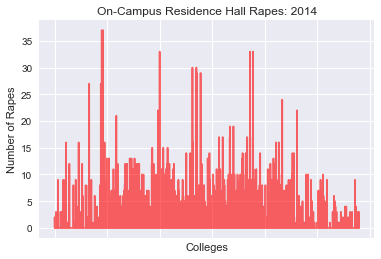

In [325]:
plt.plot(xrange(len(df)), df['RAPE15'].fillna(0), c = 'r', alpha = .6)
plt.title("On-Campus Residence Hall Rapes: 2015")
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off') # labels along the bottom edge are off
plt.xlabel('Colleges')
plt.ylabel('Number of Rapes')
plt.show()

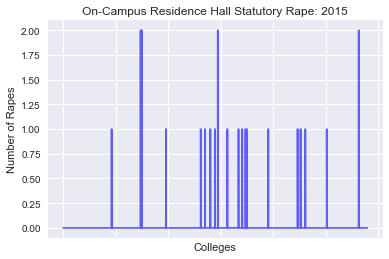

In [437]:
plt.plot(xrange(len(df)), df['STATR15'].fillna(0), c = 'b', alpha = .6)
plt.title("On-Campus Residence Hall Statutory Rape: 2015")
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off') # labels along the bottom edge are off
plt.xlabel('Colleges')
plt.ylabel('Number of Rapes')
plt.show()

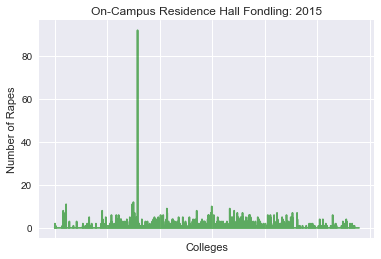

In [438]:
plt.plot(xrange(len(df)), df['FONDL15'].fillna(0), c = 'g', alpha = .6)
plt.title("On-Campus Residence Hall Fondling: 2015")
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off') # labels along the bottom edge are off
plt.xlabel('Colleges')
plt.ylabel('Number of Rapes')
plt.show()


Yikes! What is that giant spike in fondling?

In [434]:
df[df['FONDL15'] == df['FONDL15'].max()]

,UNITID_P,INSTNM,City,State,men_total15,women_total15,FORCIB13,NONFOR13,RAPE14,RAPE15,...,NONFOR7,men_total8,women_total8,FORCIB6,NONFOR6,men_total7,women_total7,FORCIB5,NONFOR5,TITLE9
2405,153658001.0,University of Iowa,IOWA CITY,IA,14898.0,15946.0,4.0,0.0,12.0,8.0,...,0.0,13.0,360.0,NaN,NaN,6242.0,9597.0,NaN,NaN,1.0


Looks like University of Iowa had some issues with fondling in 2015...

In the next chart we plot on campus residence hall rapes in 2014 and 2015 together, the former in blue and the latter in red, to see if we can see any clear decrease or trend from year to year. This plot is super not interprettable but honestly looks cool so I'm leaving it

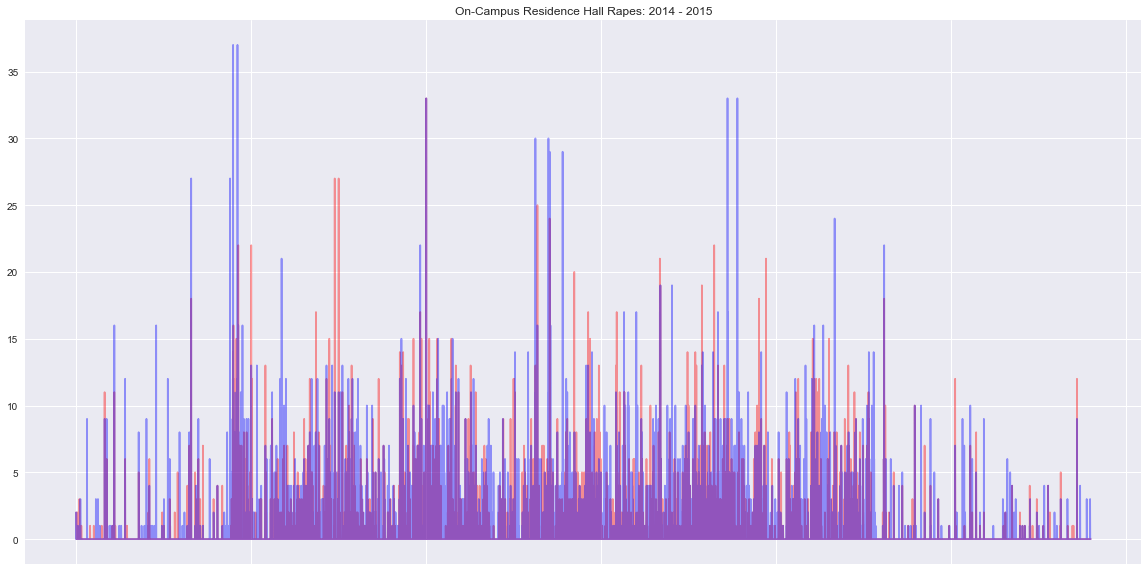

In [440]:
fig = plt.figure(figsize=(20,10))
plt.plot(xrange(len(df)), df['RAPE15'].fillna(0), c='r', alpha = .4, figure = fig)
plt.plot(xrange(len(df)), df['RAPE14'].fillna(0), c = 'b', alpha = .4, figure = fig)
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off') # labels along the bottom edge are off
plt.title("On-Campus Residence Hall Rapes: 2014 - 2015")
plt.show()

# Grabbing Title IX Data For Each College

In this section, we interact with the Chronicle's API and grab data regarding instances of Title IX investigations, add it to our dataframe, and then write it all to a CSV for use in the underlying database for the website 

In [423]:
title_list = []
for i, row in enumerate(df['UNITID_P']):
    if i % 100 == 0: 
        print i
    r = requests.get('http://projects.chronicle.com/titleix/api/v1/colleges/?college_unitid=' + str(int(row))[:-3])
    r = r.json()
    if len(r) > 0: 
        title_list.append(float(r[0]['case_count']))
    else: 
        title_list.append(float('nan'))    

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500


In [426]:
df.head()

,UNITID_P,INSTNM,City,State,men_total15,women_total15,FORCIB13,NONFOR13,RAPE14,RAPE15,...,NONFOR7,men_total8,women_total8,FORCIB6,NONFOR6,men_total7,women_total7,FORCIB5,NONFOR5,TITLE9
0,100654001.0,Alabama A & M University,NORMAL,AL,2409.0,3219.0,2.0,0.0,0.0,2.0,...,0.0,2233.0,2891.0,1.0,0.0,2505.0,3201.0,4.0,0.0,NaN
1,100663001.0,University of Alabama at Birmingham,BIRMINGHAM,AL,7185.0,11148.0,1.0,0.0,2.0,1.0,...,0.0,6431.0,9718.0,1.0,0.0,6480.0,9766.0,0.0,0.0,1.0
10,100760003.0,Central Alabama Community College,Talladega,AL,796.0,991.0,NaN,NaN,NaN,NaN,...,0.0,12525.0,12005.0,0.0,0.0,12256.0,11881.0,0.0,0.0,NaN
100,102368007.0,Troy University,Columbus,GA,6743.0,11022.0,NaN,NaN,NaN,NaN,...,0.0,264.0,539.0,0.0,0.0,1018.0,1934.0,0.0,0.0,NaN
1000,125718001.0,Westminster Theological Seminary in California,ESCONDIDO,CA,127.0,11.0,0.0,0.0,NaN,NaN,...,NaN,457.0,61.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Need to re-format the CSV to be most compatible with our JavaScript

In [471]:
def clean_row(yrs_list, row, dct): 
    for yr in yrs_list:
        full_yr = '2' + ('0' * (3 - len(yr))) + yr
        if int(yr) < 14: 
            # either forcible or nonforcible
            for key in ['FORCIB', 'NONFOR']:
                dct['YEAR'].append(full_yr)
                dct['TYPE'].append(key)
                dct['NUMBER'].append(row[key + yr])
                dct['INST'].append(row['UNITID_P'])
                dct['STATE'].append(row['State'])
                dct['TITLEIX'].append(row['TITLE9'])
                dct['NAME'].append(row['INSTNM'])
                if int(yr) >= 7: 
                    dct['MEN'].append(row['men_total' + yr])
                    dct['WOMEN'].append(row['women_total' + yr])
                else:
                    dct['MEN'].append(row['men_total7'])
                    dct['WOMEN'].append(row['women_total7'])
        else: 
            for key in ['RAPE', 'FONDL', 'STATR']: 
                dct['YEAR'].append(full_yr)
                dct['TYPE'].append(key)
                dct['NUMBER'].append(row[key + yr])
                dct['INST'].append(row['UNITID_P'])
                dct['STATE'].append(row['State'])
                dct['TITLEIX'].append(row['TITLE9'])
                dct['MEN'].append(row['men_total' + yr])
                dct['WOMEN'].append(row['women_total' + yr])
                dct['NAME'].append(row['INSTNM'])            
    return 

In [472]:
new_df = {'YEAR': [], 'TYPE': [], 'INST': [], 'NAME': [], 'STATE': [], 'TITLEIX': [], 'NUMBER': [], 'MEN': [], 'WOMEN': []}
yrs_list = ['5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15']
for index, row in df.iterrows():
    if int(index) % 1000 == 0: 
        print index
    clean_row(yrs_list, row, new_df)

0
1000
10000
11000
2000
3000
4000
5000
6000
7000
8000
9000


In [474]:
new_df = pd.DataFrame(new_df)

In [476]:
new_df.to_csv('js.csv', encoding='utf-8')